In [1]:
import numpy as np
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
class int_rounded(object):
    """
    Class to help force comparisons be made on scaled up integers,
    preventing machine precision issues cross-platforms

    Parameters
    ----------
    inval : number-like thing
        Some number that we want to compare
    scale : float (1e5)
        How much to scale inval before rounding and converting to an int.
    """
    def __init__(self, inval, scale=1e5):
        self.initial = inval
        self.value = np.round(inval * scale).astype(int)
        self.scale = scale

    def __eq__(self, other):
        return self.value == other.value

    def __ne__(self, other):
        return self.value != other.value

    def __lt__(self, other):
        return self.value < other.value

    def __le__(self, other):
        return self.value <= other.value

    def __gt__(self, other):
        return self.value > other.value

    def __ge__(self, other):
        return self.value >= other.value

    def __repr__(self):
        return str(self.initial)

    def __add__(self, other):
        out_scale = np.min([self.scale, other.scale])
        result = int_rounded(self.initial + other.initial, scale=out_scale)
        return result

    def __sub__(self, other):
        out_scale = np.min([self.scale, other.scale])
        result = int_rounded(self.initial - other.initial, scale=out_scale)
        return result

    def __mul__(self, other):
        out_scale = np.min([self.scale, other.scale])
        result = int_rounded(self.initial * other.initial, scale=out_scale)
        return result

    def __div__(self, other):
        out_scale = np.min([self.scale, other.scale])
        result = int_rounded(self.initial / other.initial, scale=out_scale)
        return result


In [3]:
def _angularSeparation(long1, lat1, long2, lat2):
    """
    Angular separation between two points in radians

    Parameters
    ----------
    long1 is the first longitudinal coordinate in radians

    lat1 is the first latitudinal coordinate in radians

    long2 is the second longitudinal coordinate in radians

    lat2 is the second latitudinal coordinate in radians

    Returns
    -------
    The angular separation between the two points in radians

    Calculated based on the haversine formula
    From http://en.wikipedia.org/wiki/Haversine_formula
    """
    are_arrays_1 = _validate_inputs([long1, lat1],
                                    ['long1', 'lat1'],
                                    'angularSeparation')

    are_arrays_2 = _validate_inputs([long2, lat2],
                                    ['long2', 'lat2'],
                                    'angularSeparation')

    # The code below is necessary because the call to np.radians() in
    # angularSeparation() will automatically convert floats
    # into length 1 numpy arrays, confusing validate_inputs()
    if are_arrays_1 and len(long1) == 1:
        are_arrays_1 = False
        long1 = long1[0]
        lat1 = lat1[0]

    if are_arrays_2 and len(long2) == 1:
        are_arrays_2 = False
        long2 = long2[0]
        lat2 = lat2[0]

    if are_arrays_1 and are_arrays_2:
        if len(long1) != len(long2):
            raise RuntimeError("You need to pass arrays of the same length "
                               "as arguments to angularSeparation()")

    t1 = np.sin(lat2/2.0 - lat1/2.0)**2
    t2 = np.cos(lat1)*np.cos(lat2)*np.sin(long2/2.0 - long1/2.0)**2
    _sum = t1 + t2

    if isinstance(_sum, numbers.Number):
        if _sum<0.0:
            _sum = 0.0
    else:
        _sum = np.where(_sum<0.0, 0.0, _sum)

    return 2.0*np.arcsin(np.sqrt(_sum))


In [4]:
def _hpid2RaDec(nside, hpids, **kwargs):
    """
    Correct for healpy being silly and running dec from 0-180.

    Parameters
    ----------
    nside : int
        Must be a value of 2^N.
    hpids : np.array
        Array (or single value) of healpixel IDs.

    Returns
    -------
    raRet : float (or np.array)
        RA positions of the input healpixel IDs. In radians.
    decRet : float (or np.array)
        Dec positions of the input healpixel IDs. In radians.
    """

    lat, lon = hp.pix2ang(nside, hpids, **kwargs)
    decRet = np.pi / 2.0 - lat
    raRet = lon

    return raRet, decRet



In [5]:
def ra_dec_hp_map(nside=None):
    """
    Return all the RA,dec points for the centers of a healpix map, in radians.
    """
    if nside is None:
        nside = set_default_nside()
    ra, dec = _hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
    return ra, dec



def WFD_healpixels(nside=None, dec_min=-62.5, dec_max=3.6):
    """
    Define a region based on declination limits only.

    Parameters
    ----------
    nside : int, opt
        Resolution for the healpix maps.
        Default None uses lsst.sims.featureScheduler.utils.set_default_nside to set default (often 32).
    dec_min : float, opt
        Minimum declination of the region (deg). Default -62.5.
    dec_max : float, opt
        Maximum declination of the region (deg). Default 3.6.

    Returns
    -------
    np.ndarray
        Healpix map with regions in declination-limited 'wfd' region as 1.
    """
    if nside is None:
        nside = set_default_nside()

    ra, dec = ra_dec_hp_map(nside=nside)
    result = np.zeros(ra.size, float)
    dec = int_rounded(dec)
    good = np.where((dec >= int_rounded(np.radians(dec_min))) &
                    (dec <= int_rounded(np.radians(dec_max))))
    result[good] = 1
    return result


def WFD_no_dust_healpixels(nside, dec_min=-72.25, dec_max=12.4, dust_limit=0.19):
    """Define a WFD region with a dust extinction limit.

    Parameters
    ----------
    nside : int, opt
        Resolution for the healpix maps.
        Default None uses lsst.sims.featureScheduler.utils.set_default_nside to set default (often 32).
    dec_min : float, opt
        Minimum dec of the region (deg). Default -72.5 deg.
    dec_max : float, opt.
        Maximum dec of the region (deg). Default 12.5 deg.
        1.75 is the FOV radius in deg.
    dust_limit : float, None
        Remove pixels with E(B-V) values greater than dust_limit from the footprint.

    Returns
    -------
    result : numpy array
    """
    if nside is None:
        nside = set_default_nside()

    ra, dec = ra_dec_hp_map(nside=nside)
    dustmap = get_dustmap(nside)

    result = np.zeros(ra.size, float)
    # First set based on dec range.
    dec = int_rounded(dec)
    good = np.where((dec >= int_rounded(np.radians(dec_min))) &
                    (dec <= int_rounded(np.radians(dec_max))))
    result[good] = 1
    # Now remove areas with dust extinction beyond the limit.
    result = np.where(dustmap >= dust_limit, 0, result)
    return result


def SCP_healpixels(nside=None, dec_max=-60.):
    """
    Define the South Celestial Pole region. Return a healpix map with SCP pixels as 1.
    """
    if nside is None:
        nside = set_default_nside()

    ra, dec = ra_dec_hp_map(nside=nside)
    result = np.zeros(ra.size, float)
    good = np.where(int_rounded(dec) < int_rounded(np.radians(dec_max)))
    result[good] = 1
    return result


def NES_healpixels(nside=None, min_EB=-30.0, max_EB = 10.0, dec_min=2.8):
    """
    Define the North Ecliptic Spur region. Return a healpix map with NES pixels as 1.

    Parameters
    ----------
    nside : int
        A valid healpix nside
    min_EB : float (-30.)
        Minimum barycentric true ecliptic latitude (deg)
    max_EB : float (10.)
        Maximum barycentric true ecliptic latitude (deg)
    dec_min : float (2.8)
        Minimum dec in degrees

    Returns
    -------
    result : numpy array
    """
    if nside is None:
        nside = set_default_nside()

    ra, dec = ra_dec_hp_map(nside=nside)
    result = np.zeros(ra.size, float)
    coord = SkyCoord(ra=ra*u.rad, dec=dec*u.rad)
    eclip_lat = coord.barycentrictrueecliptic.lat.radian
    eclip_lat = int_rounded(eclip_lat)
    dec = int_rounded(dec)
    good = np.where((eclip_lat > int_rounded(np.radians(min_EB))) &
                    (eclip_lat < int_rounded(np.radians(max_EB))) &
                    (dec > int_rounded(np.radians(dec_min))))
    result[good] = 1

    return result


def galactic_plane_healpixels(nside=None, center_width=10., end_width=4.,
                              gal_long1=290., gal_long2=70.):
    """
    Define a Galactic Plane region.

    Parameters
    ----------
    nside : int, opt
        Resolution for the healpix maps.
        Default None uses lsst.sims.featureScheduler.utils.set_default_nside to set default (often 32).
    center_width : float, opt
        Width at the center of the galactic plane region.
    end_width : float, opt
        Width at the remainder of the galactic plane region.
    gal_long1 : float, opt
        Longitude at which to start the GP region.
    gal_long2 : float, opt
        Longitude at which to stop the GP region.
        Order matters for gal_long1 / gal_long2!

    Returns
    -------
    np.ndarray
        Healpix map with galactic plane regions set to 1.
    """
    if nside is None:
        nside = set_default_nside()
    ra, dec = ra_dec_hp_map(nside=nside)

    coord = SkyCoord(ra=ra*u.rad, dec=dec*u.rad)
    gal_lon, gal_lat = coord.galactic.l.deg, coord.galactic.b.deg
    # Reject anything beyond the central width.
    sky = np.where(np.abs(gal_lat) < center_width, 1, 0)
    # Apply the galactic longitude cuts, so that plane goes between gal_long1 to gal_long2.
    # This is NOT the shortest distance between the angles.
    gp_length = (gal_long2 - gal_long1) % 360
    # If the length is greater than 0 then we can add additional cuts.
    if gp_length > 0:
        # First, remove anything outside the gal_long1/gal_long2 region.
        sky = np.where(int_rounded((gal_lon - gal_long1) % 360) < int_rounded(gp_length), sky, 0)
        # Add the tapers.
        # These slope from the center (gp_center @ center_width)
        # to the edge (gp_center + gp_length/2 @ end_width).
        half_width = gp_length / 2.
        slope = (center_width - end_width) / half_width
        gp_center = (gal_long1 + half_width) % 360
        gp_dist = gal_lon - gp_center
        gp_dist = np.abs(np.where(int_rounded(gp_dist) > int_rounded(180), (180 - gp_dist) % 180, gp_dist))
        lat_limit = np.abs(center_width - slope * gp_dist)
        sky = np.where(int_rounded(np.abs(gal_lat)) < int_rounded(lat_limit), sky, 0)
    return sky


def magellanic_clouds_healpixels(nside=None, lmc_radius=10, smc_radius=5):
    """
    Define the Galactic Plane region. Return a healpix map with GP pixels as 1.
    """
    if nside is None:
        nside = set_default_nside()
    ra, dec = ra_dec_hp_map(nside=nside)
    result = np.zeros(hp.nside2npix(nside))

    lmc_ra = np.radians(80.893860)
    lmc_dec = np.radians(-69.756126)
    lmc_radius = np.radians(lmc_radius)

    smc_ra = np.radians(13.186588)
    smc_dec = np.radians(-72.828599)
    smc_radius = np.radians(smc_radius)

    dist_to_lmc = _angularSeparation(lmc_ra, lmc_dec, ra, dec)
    lmc_pix = np.where(int_rounded(dist_to_lmc) < int_rounded(lmc_radius))
    result[lmc_pix] = 1

    dist_to_smc = _angularSeparation(smc_ra, smc_dec, ra, dec)
    smc_pix = np.where(int_rounded(dist_to_smc) < int_rounded(smc_radius))
    result[smc_pix] = 1
    return result


def generate_goal_map(nside=None, NES_fraction = .3, WFD_fraction = 1.,
                      SCP_fraction=0.4, GP_fraction = 0.2,
                      NES_min_EB = -30., NES_max_EB = 10, NES_dec_min = 3.6,
                      SCP_dec_max=-62.5, gp_center_width=10.,
                      gp_end_width=4., gp_long1=290., gp_long2=70.,
                      wfd_dec_min=-62.5, wfd_dec_max=3.6,
                      generate_id_map=False):
    """
    Handy function that will put together a target map in the proper order.
    """
    if nside is None:
        nside = set_default_nside()

    # Note, some regions overlap, thus order regions are added is important.
    result = np.zeros(hp.nside2npix(nside), dtype=float)
    id_map = np.zeros(hp.nside2npix(nside), dtype=int)
    pid = 1
    prop_name_dict = dict()

    if NES_fraction > 0.:
        nes = NES_healpixels(nside=nside, min_EB = NES_min_EB, max_EB = NES_max_EB,
                             dec_min=NES_dec_min)
        result[np.where(nes != 0)] = 0
        result += NES_fraction*nes
        id_map[np.where(nes != 0)] = 1
        pid += 1
        prop_name_dict[1] = 'NorthEclipticSpur'

    if WFD_fraction > 0.:
        wfd = WFD_healpixels(nside=nside, dec_min=wfd_dec_min, dec_max=wfd_dec_max)
        result[np.where(wfd != 0)] = 0
        result += WFD_fraction*wfd
        id_map[np.where(wfd != 0)] = 3
        pid += 1
        prop_name_dict[3] = 'WideFastDeep'

    if SCP_fraction > 0.:
        scp = SCP_healpixels(nside=nside, dec_max=SCP_dec_max)
        result[np.where(scp != 0)] = 0
        result += SCP_fraction*scp
        id_map[np.where(scp != 0)] = 2
        pid += 1
        prop_name_dict[2] = 'SouthCelestialPole'

    if GP_fraction > 0.:
        gp = galactic_plane_healpixels(nside=nside, center_width=gp_center_width,
                                       end_width=gp_end_width, gal_long1=gp_long1,
                                       gal_long2=gp_long2)
        result[np.where(gp != 0)] = 0
        result += GP_fraction*gp
        id_map[np.where(gp != 0)] = 4
        pid += 1
        prop_name_dict[4] = 'GalacticPlane'

    if generate_id_map:
        return result, id_map, prop_name_dict
    else:
        return result


def standard_goals(nside=None):
    """
    A quick function to generate the "standard" goal maps. This is the traditional WFD/mini survey footprint.
    """
    if nside is None:
        nside = set_default_nside()

    result = {}
    result['u'] = generate_goal_map(nside=nside, NES_fraction=0.,
                                    WFD_fraction=0.31, SCP_fraction=0.15,
                                    GP_fraction=0.15,
                                    wfd_dec_min=-62.5, wfd_dec_max=3.6)
    result['g'] = generate_goal_map(nside=nside, NES_fraction=0.2,
                                    WFD_fraction=0.44, SCP_fraction=0.15,
                                    GP_fraction=0.15,
                                    wfd_dec_min=-62.5, wfd_dec_max=3.6)
    result['r'] = generate_goal_map(nside=nside, NES_fraction=0.46,
                                    WFD_fraction=1.0, SCP_fraction=0.15,
                                    GP_fraction=0.15,
                                    wfd_dec_min=-62.5, wfd_dec_max=3.6)
    result['i'] = generate_goal_map(nside=nside, NES_fraction=0.46,
                                    WFD_fraction=1.0, SCP_fraction=0.15,
                                    GP_fraction=0.15,
                                    wfd_dec_min=-62.5, wfd_dec_max=3.6)
    result['z'] = generate_goal_map(nside=nside, NES_fraction=0.4,
                                    WFD_fraction=0.9, SCP_fraction=0.15,
                                    GP_fraction=0.15,
                                    wfd_dec_min=-62.5, wfd_dec_max=3.6)
    result['y'] = generate_goal_map(nside=nside, NES_fraction=0.,
                                    WFD_fraction=0.9, SCP_fraction=0.15,
                                    GP_fraction=0.15,
                                    wfd_dec_min=-62.5, wfd_dec_max=3.6)
    return result


In [6]:
sg = standard_goals(nside=32)

In [7]:
sg

{'u': array([0.  , 0.  , 0.  , ..., 0.15, 0.15, 0.15]),
 'g': array([0.  , 0.  , 0.  , ..., 0.15, 0.15, 0.15]),
 'r': array([0.  , 0.  , 0.  , ..., 0.15, 0.15, 0.15]),
 'i': array([0.  , 0.  , 0.  , ..., 0.15, 0.15, 0.15]),
 'z': array([0.  , 0.  , 0.  , ..., 0.15, 0.15, 0.15]),
 'y': array([0.  , 0.  , 0.  , ..., 0.15, 0.15, 0.15])}

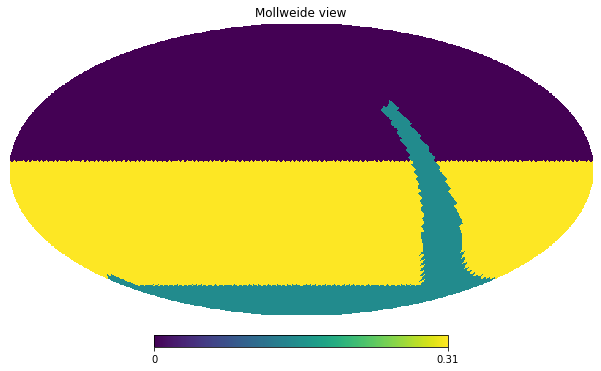

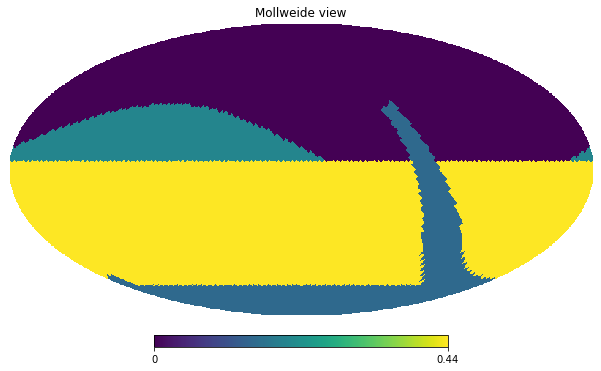

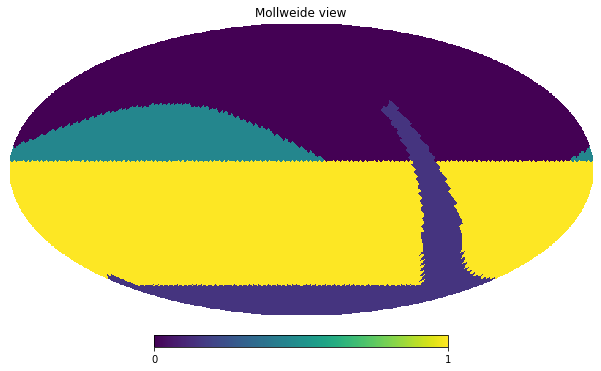

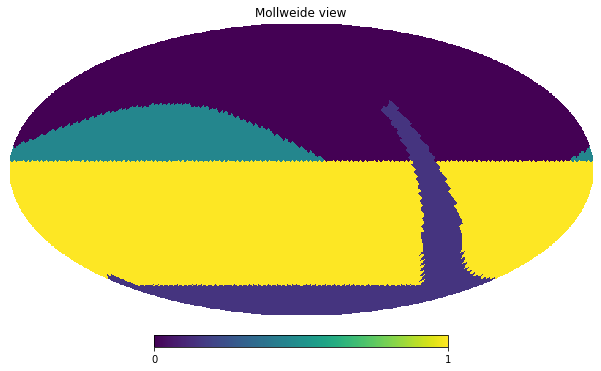

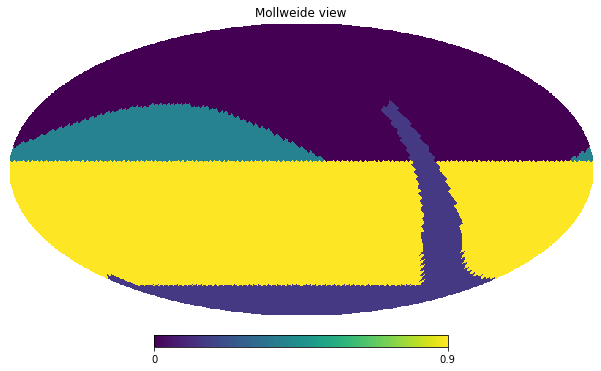

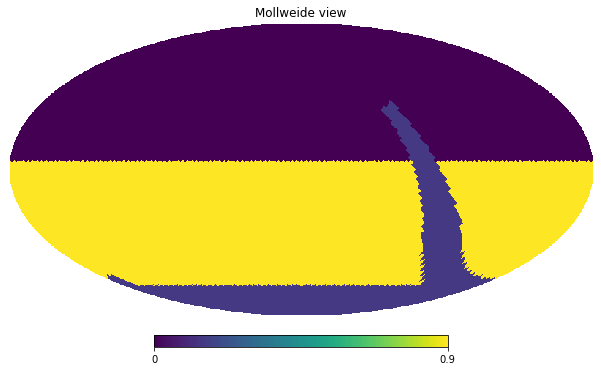

In [8]:
for key in sg:
    hp.mollview(sg[key])